In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import tidytcells

In [2]:
raw_dir = Path('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/raw/tanno')
preprocessed_dir = Path('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno')

In [3]:
example = pd.read_csv(
    raw_dir/'data'/'A1 memory.txt',
    sep='\t'
)

In [4]:
example.sort_values(by='Clustered', ascending=False).head()

,Clustered,Collapsed,ClusterID,CDRH3_AA,CDRL3_AA,CDRH3_NT,CDRL3_NT,VH,DH,JH,VL,JL
0,8899,5544,1,CASSLQGARETQYF,CALLSTGGGNKLTF,TGTGCCAGCAGCTTACAGGGGGCGCGGGAGACCCAGTACTTC,TGTGCTCTCCTTTCCACGGGAGGAGGAAACAAACTCACCTTT,TRBV11-2,TRBD1,TRBJ2-5,TRAV9-2,TRAJ10
1,1945,1077,2,CSWKREIVEQFF,CAVSDRNTNAGKSTF,TGCAGTTGGAAGCGGGAGATAGTTGAGCAGTTCTTC,TGTGCTGTGAGTGATAGGAACACCAATGCAGGCAAATCAACCTTT,TRBV20-1,TRBD2,TRBJ2-1,TRAV8-4,TRAJ27
2,1215,867,3,CASSSQGANTEAFF,CIVRKRNQFYF,TGTGCCAGCAGCTCCCAAGGAGCGAACACTGAAGCTTTCTTT,TGCATCGTCAGAAAACGTAACCAGTTCTATTTT,TRBV9,NaN,TRBJ1-1,TRAV26-1,TRAJ49
3,1185,866,4,CASSFQGQGGQPQHF,CAVRPRDTGGFKTIF,TGTGCCAGCAGTTTCCAGGGACAGGGCGGTCAGCCCCAGCATTTT,TGTGCTGTGAGGCCTCGGGATACTGGAGGCTTCAAAACTATCTTT,TRBV12-3,TRBD1,TRBJ1-5,TRAV21,TRAJ9
4,1002,785,5,CSAPLAGVSYNEQFF,CIVRSYNYGQNFVF,TGCAGTGCGCCACTAGCGGGCGTCTCCTACAATGAGCAGTTCTTC,TGCATCGTCAGATCTTATAACTATGGTCAGAATTTTGTCTTT,TRBV20-1,TRBD2,TRBJ2-1,TRAV26-1,TRAJ26


In [5]:
dfs = []

for f in (raw_dir/'data').iterdir():
    df = pd.read_csv(f,sep='\t')

    # Filter for potential mispairings
    df = df.sort_values(by='Clustered', ascending=False)
    df = df.drop_duplicates('CDRH3_NT', keep='first')
    df = df.drop_duplicates('CDRL3_NT', keep='first')

    df = df[
        ['VL', 'CDRL3_AA', 'JL', 'VH', 'CDRH3_AA', 'JH']
    ]
    df = df.drop_duplicates()
    df.columns = ['TRAV', 'CDR3A', 'TRAJ', 'TRBV', 'CDR3B', 'TRBJ']
    df['Epitope'] = pd.NA
    df['MHCA'] = pd.NA
    df['MHCB'] = pd.NA
    df['duplicate_count'] = pd.NA

    dfs.append(df)

combined = pd.concat(dfs, axis='index')
combined = combined.drop_duplicates()
combined = combined.sort_values(
    by=combined.columns.tolist(),
    ignore_index=True
)

In [6]:
combined['TRAV'] = combined['TRAV'].map(lambda x: tidytcells.tcr.standardise(x+'*01', enforce_functional=True))
combined['TRAJ'] = combined['TRAJ'].map(lambda x: tidytcells.tcr.standardise(x+'*01', enforce_functional=True))
combined['TRBV'] = combined['TRBV'].map(lambda x: tidytcells.tcr.standardise(x+'*01', enforce_functional=True))
combined['TRBJ'] = combined['TRBJ'].map(lambda x: tidytcells.tcr.standardise(x+'*01', enforce_functional=True))

/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.10/site-packages/tidytcells/_utils/warnings.py:10: UserWarning: Failed to standardise: "TRAV11*01" for species homosapiens. Attempted fix "TRAV11*01" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.10/site-packages/tidytcells/_utils/warnings.py:10: UserWarning: Failed to standardise: "TRAV15*01" for species homosapiens. Attempted fix "TRAV15*01" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.10/site-packages/tidytcells/_utils/warnings.py:10: UserWarning: Failed to standardise: "TRAV32*01" for species homosapiens. Attempted fix "TRAV32*01" did not meet the standardised format requirements. Ignoring this gene name...
  warn(
/home/yutanagano/Projects/tcr_embedder/.venv/lib64/python3.10/site-packages/tidytcells/_utils/warnings.py:10: UserW

<AxesSubplot: >

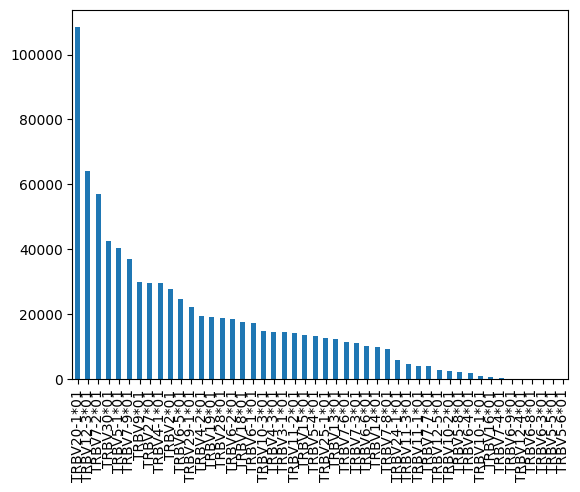

In [7]:
combined['TRBV'].value_counts().plot.bar()

In [8]:
combined.to_csv(preprocessed_dir/'combined.csv', index=False)

In [9]:
test_frac = 0.1
test_rows = int(test_frac * len(combined))

shuffled = combined.sample(frac=1, random_state=420)

test = shuffled.iloc[:test_rows]
train = shuffled.iloc[test_rows:]

In [10]:
travs = tidytcells.tcr.query(precision='gene', functionality='F', contains='TRAV')
trajs = tidytcells.tcr.query(precision='gene', functionality='F', contains='TRAJ')
trbvs = tidytcells.tcr.query(precision='gene', functionality='F', contains='TRBV')
trbjs = tidytcells.tcr.query(precision='gene', functionality='F', contains='TRBJ')

In [11]:
for dataset in (train, test):
    assert dataset['TRAV'].nunique() == len(travs)
    assert not(set([g+'*01' for g in travs]) - set(dataset['TRAV']))
    assert dataset['TRAJ'].nunique() == len(trajs)
    assert not(set([g+'*01' for g in trajs]) - set(dataset['TRAJ']))
    assert dataset['TRBV'].nunique() == len(trbvs)
    assert not(set([g+'*01' for g in trbvs]) - set(dataset['TRBV']))
    assert dataset['TRBJ'].nunique() == len(trbjs)
    assert not(set([g+'*01' for g in trbjs]) - set(dataset['TRBJ']))
    print(dataset['TRBV'].value_counts())

TRBV20-1*01    97492
TRBV12-3*01    57756
TRBV7-2*01     51351
TRBV30*01      38143
TRBV5-1*01     36462
TRBV7-9*01     33495
TRBV9*01       27154
TRBV27*01      26669
TRBV4-1*01     26585
TRBV2*01       24967
TRBV6-5*01     22318
TRBV29-1*01    19902
TRBV4-2*01     17603
TRBV19*01      17273
TRBV28*01      16807
TRBV6-2*01     16661
TRBV18*01      15992
TRBV6-1*01     15623
TRBV10-3*01    13384
TRBV4-3*01     13211
TRBV3-1*01     13018
TRBV11-2*01    12839
TRBV15*01      12186
TRBV5-4*01     11898
TRBV25-1*01    11284
TRBV13*01      11080
TRBV7-6*01     10278
TRBV7-3*01      9948
TRBV6-6*01      9174
TRBV14*01       8857
TRBV7-8*01      8373
TRBV24-1*01     5257
TRBV11-3*01     4172
TRBV11-1*01     3630
TRBV7-7*01      3599
TRBV12-5*01     2601
TRBV10-2*01     2230
TRBV5-8*01      1975
TRBV6-4*01      1806
TRBV10-1*01      950
TRBV16*01        506
TRBV7-4*01       389
TRBV12-4*01      150
TRBV6-9*01       144
TRBV6-8*01       141
TRBV6-3*01        99
TRBV5-6*01        55
TRBV5-5*01   

In [12]:
train.to_csv(preprocessed_dir/'train.csv', index=False)
test.to_csv(preprocessed_dir/'test.csv', index=False)